# About `BS5` and its interpolants

## The method

The 3rd order Bogacki Shampine method ('RK23' in scipy) is better known, but this notebook is about their 5th order method.

### Other fifth order methods
Before discussing Bogacki-Shampine's fifth order method `BS5`, I think it's useful to comment on its famous predecessor by Dormand and Prince. This is also a 5th order method, known as 'RK45' in scipy, 'ode45' in Matlab, 'DP5' in Julia and 'dopri5' in Fortran. (I will refer to it as 'DP5', because 'RK45' is unclear) It is the default method of `solve_ivp` and it indeed is a good choice for many problems (that are non-stiff and solved to medium accuracy).

The attractive features implemented in this method by Dormand and Prince are:
* Local extrapolation: The higher (5th) order method is used to propagate the integration, while the lower (4th) order method is used for error estimation. The coefficients are tuned to minimize the error of the 5th order method.
* 6 stages are used per step: the minimum for a 5th order method.
* First same as last (FSAL): the derivative of the output point is used for the error estimate. Although this does not explain the name, I think that the standard explanation of FSAL is more confusing. (The evaluation of the output point used by the error estimator can also be used for the first stage of the next step, because it's the same point.)

The success of the method of Dormand and Prince seems to have attracted several researchers to come up with an even better method. Julia recommends the method of [Tsitsouras](https://doi.org/10.1016/j.camwa.2011.06.002), which I have included in Extensisq as `Ts5`. This method uses fewer simplifying assumptions to get more freedom in tuning the coefficients for lower error constants.

### Bogacki and Shampine's fifth order method
I prefer the method `BS5` of [Bogacki and Shampine](https://doi.org/10.1016/0898-1221%2896%2900141-1) over DP5 and `Ts5` as the go-to method. This notebook may convince you too. The base of this method is a 6th order 7 stage method in which the 6th order convergence was sacrificed for stability and robust error control. The result is a 5th order method that uses one stage more than the minimum required, but that makes up for this by being more efficient. (It can take larger steps for a given tolerance.)

The benefits of the `BS5` method, compared to DP5 are:
* **Comparable stability region.** The stability region is about 7/6 times larger than DP5's region, to compensate for the extra stage. The stability along the imaginary axis is increased much more (about 40% on top of the factor 7/6).
* **Efficient and robust error control.** The method contains two error estimates. The main estimate needs only 5 function evaluations (DP5 needs 6). If the solution is smooth, this error estimate will reject the step if needed. However, if the solution has a sharp change above c=3/4, this error estimate cannot weigh that. Therefore, a second error estimate is included (using FSAL) to increase robustness in such cases.  Both embedded 4th order methods for the error estimates have nearly the same stability region as the main method.
* **Very low 6th order error constants**, and low error constants up to order 9.
* **Three interpolants** with different efficiency/accuracy trade-offs.

The figure shows the stability regions, which are nearly the same for the three embedded methods. (The red area for stiffness detection can be ignored for this notebook.)

![Stability region](stability%20regions/stabilityBS5.png)

Enough rambling; let's run a demo.

### Demo

The demo problem is Duffing's equation. This is a mass spring system with a non-linear spring. In this case, the system is undamped, with a softening spring and a sinusoidal excitation force. It's problem E3 from the [DETEST](http://perso.ensta-paristech.fr/~chapoutot/integration/docs/p1-enright.pdf) set.

#### Problem definition

The problem is defined in a dictionary.

In [1]:
from math import sin

problem = {"fun" : lambda t, y: [y[1], y[0]**3/6 - y[0] + 2*sin(2.78535*t)],
            "y0" : [0., 0.],
        "t_span" : [0., 20.]}

Before testing with `BS5`, I create a reference solution with high accuracy. The higher order methods of [Prince](http://www.peteprince.co.uk/parallel.pdf) are well suited for that, because of their high order interpolants. Here I chose `Pr8`, but it could have been `Pr7` or `Pr9` as well. (Or `solve_ivp`'s 'DOP853', also by (Dormand and) Prince.)

In [2]:
from scipy.integrate import solve_ivp
from extensisq import Pr8, BS5, Ts5

sol_ref = solve_ivp(**problem, method=Pr8, dense_output=True, rtol=1e-12, atol=1e-12)

#### Solution plot

A plot gives an idea about the solution. The response appears to have two sine components. (This problem can become chaotic, depending on the excitation.)

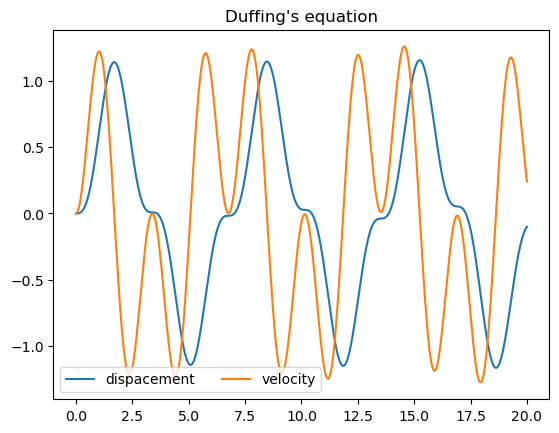

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t_fine = np.linspace(*problem["t_span"], 1000)

plt.plot(t_fine, sol_ref.sol(t_fine).T)
plt.title("Duffing's equation")
plt.legend(("dispacement", "velocity"), ncol=2)
plt.show()

#### Solving with `BS5` and other 5th order methods 

The same problem is solved with default accuracy using the `BS5` method and the DP5 ('RK45') method. I print the cost (number of function evaluations) and the error norms.

In [4]:
from numpy.linalg import norm

def error(sol, ref=sol_ref.sol):
    return norm(sol.y - ref(sol.t))

sol_BS5 = solve_ivp(**problem, method=BS5)
sol_DP5 = solve_ivp(**problem, method="RK45")

print("Method  Cost    Error")
print(f" BS5    {sol_BS5.nfev}   {error(sol_BS5):.2e}")
print(f" DP5    {sol_DP5.nfev}   {error(sol_DP5):.2e}")

Method  Cost    Error
 BS5    212   9.22e-03
 DP5    356   2.51e-01


The error from `BS5` is **26 times** smaller, while DP5 has used **68%** more evaluations! That's why I like `BS5`.

While we are at it, why not also test Tsitsouras's method `Ts5` (recommended by Julia).

In [5]:
sol_Ts5 = solve_ivp(**problem, method=Ts5)
print("Method  Cost    Error")
print(f" Ts5    {sol_Ts5.nfev}   {error(sol_Ts5):.2e}")

Method  Cost    Error
 Ts5    341   3.67e-02


`Ts5` performs better than DP5, but `BS5` still beats `TS5` with a 4x lower error, and `Ts5` uses 61% more evaluations. Of course I picked a problem that makes `BS5` look good. But that was not a very hard thing to do. It will beat DP5 (and `TS5`) for many cases. 

There is one thing to keep in mind however: the efficiency of `BS5` starts to decrease when the tolerances are set looser than the default values of `solve_ivp`; see, for example, [the notebook that compares the 5th order methods](all_methods.ipynb). Better yet, try it on your non-stiff problem and see for yourself how this method performs.

## Interpolants

A good method needs a good interpolant. `BS5` of Extensisq has 3 different interpolants. Why 3? Read along!

### Cost

Bogacki and Shampine created a very accurate interpolant for this method. It needs 3 extra function evaluations for each step in which the interpolant is used. That is all steps if the option 'dense_ouput' is used.

I have added two other interpolants:
* 'free': 4th order interpolant that needs no extra evaluations
* 'low': 5th order interpolant that needs one extra evaluation (low cost).

Of course, the errors for these interpolants are larger than for the original ('best') interpolant, but let's look at the number of function evaluations first.

In [6]:
sol_free = solve_ivp(**problem, method=BS5, dense_output=True, interpolant="free")
sol_low = solve_ivp(**problem, method=BS5, dense_output=True, interpolant="low")
sol_best = solve_ivp(**problem, method=BS5, dense_output=True, interpolant="best")

print("Cost (4th order) free interpolant:    ", sol_free.nfev)
print("Cost (5th order) low cost interpolant:", sol_low.nfev)
print("Cost (5th order) original interpolant:", sol_best.nfev)

Cost (4th order) free interpolant:     212
Cost (5th order) low cost interpolant: 238
Cost (5th order) original interpolant: 290


As expected, the number of evaluations for the 'free' interpolant is the same as without interpolant (dense_output). The increases in evaluation count for 'low' and 'best' are slightly lower than the maximum values of 8/7 and 10/7, because there are a few failed steps (that do not get an interpolator of course).

The method is still more efficient than DP5 (and `Ts5`) for this problem, even with the 'best' interpolant. However, this will not be the case for many problems. This begs the question if we really need the superior accuracy of the 'best' interpolant.

### Accuracy

Let's start with the free interpolant. The figure shows the norm of the 5th order error constants over the step. We want this line to be as low as possible. If we can get it to 0 over the entire step, then we have an interpolant of 5th order (and we should look at the norm of 6th order error constants instead).

![Free interpolant](interpolants/interpolation_BS5_free.png)

The error of the free interpolant is high compared to the error of the embedded method of `BS5` and also to that of DP5. This makes this interpolant unattractive for cases that require some accuracy guarantees. It can still be perfectly fine for plotting though (which we will test later).

Notice that the point at 0.5 (halfway the step) has error 0 and therefore is of order 5. This is the point at which we do an extra evaluation. The derivative from this evaluation can be used to create a more accurate interpolant that turns out to be of 5th order. Therefore, we plot the norm of the 6th order error constants over the step to evaluate this interpolant.

![Low interpolant](interpolants/interpolation_BS5_low.png)

The amplitude in this graph is not that much lower than in the graph for the free interpolant, but we are looking at higher order terms now. The level at the end point (1) is equal to the error of the main method and the maximum error in the middle of the step is much higher than that. However, this is mainly because the `BS5` method has such a low error. To put this in perspective, I have also plotted the level of the main method of DP5 in the graph. Now we can see that the error of the 'low' cost interpolant is much lower than that. (By the way, the DP5 method in scipy ('RK45') has a free interpolant of fourth order.)

Bogacki and Shampine wanted to create an interpolant that is much more accurate still. The graph of the 6th order error constants of this interpolant shows that they have succeeded to remain under the level of the main method for the entire step. So use this interpolant if accuracy is very important. For example to track events. (This how Bogacki and Shampine intended it to be used.)

![Best interpolant](interpolants/interpolation_BS5_best.png)

Now let's make some plots that compare the interpolants.

### Plots

First I should keep my promise by showing that the 'free' interpolant can be sufficiently accurate for plotting solutions.

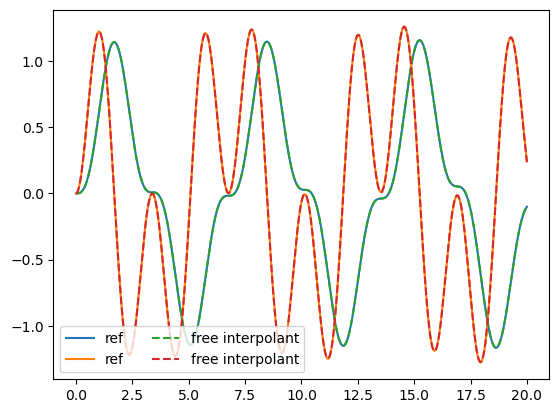

In [7]:
plt.plot(t_fine, sol_ref.sol(t_fine).T, label="ref")
plt.plot(t_fine, sol_free.sol(t_fine).T, '--', label="free interpolant")
plt.legend(ncol=2)
plt.show()

No differences are apparent from this plot which compares the accurate reference solution to the solution with the 'free' interpolant.

To see the differences, I set a large (loose) absolute tolerance and a large first step.

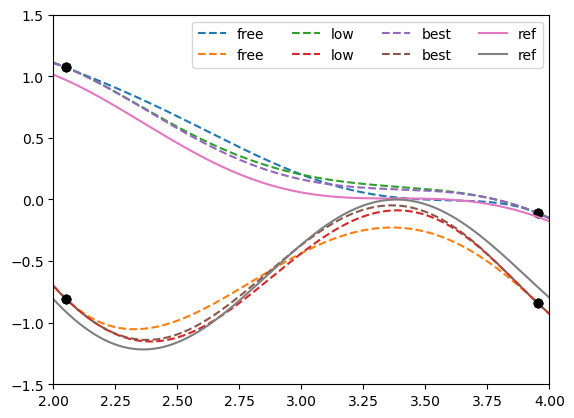

In [8]:

interpolants = ["free", "low", "best"]
for interpolant in interpolants:
    sol = solve_ivp(**problem, method=BS5, dense_output=True, 
                    interpolant=interpolant, atol=0.022, first_step=2.05)
    plt.plot(t_fine, sol.sol(t_fine).T, '--', label=interpolant)
    plt.plot(sol.t, sol.y.T, 'ok')
plt.plot(t_fine, sol_ref.sol(t_fine).T, label="ref")

plt.xlim((2, 4))
plt.ylim((-1.5, 1.5))
plt.legend(ncol=4)
plt.show()

The figure looks at the early part of the integration interval, and already the main solution (the dots) start to deviate from the reference solution. Nevertheless, the 'free' interpolant clearly tends to cut corners in both the displacement (top) and velocity (bottom) solutions. The 'low' (cost) interpolant does a much better job. We know from the figures above that it has the largest error in the middle of the step (halfway the dots). This seems to explain the deviation from the 'best' interpolant in these results.

### Error plots

Now at default tolerances, we need to look at the actual error, instead of the solutions themselves, to be able to see what's going on. This is done next, starting with the 'best' interpolant.

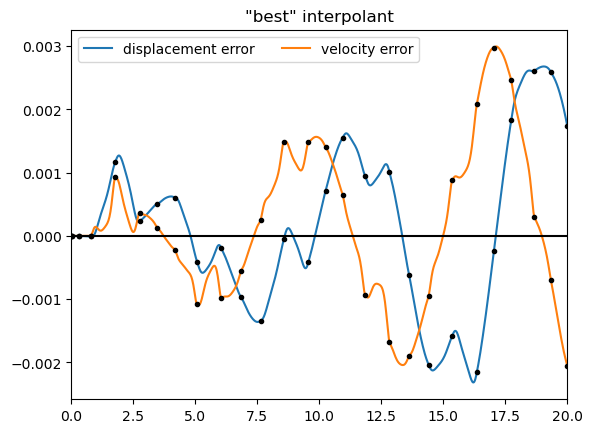

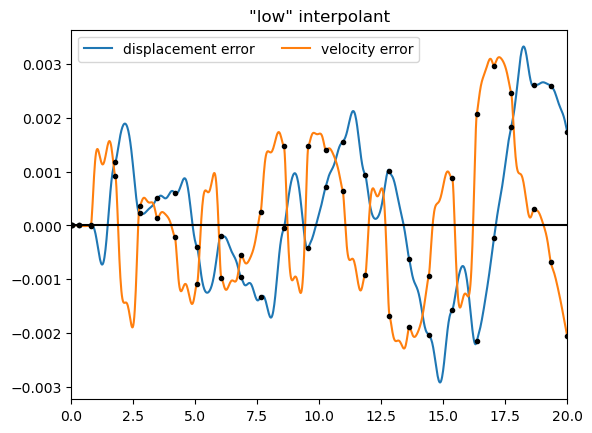

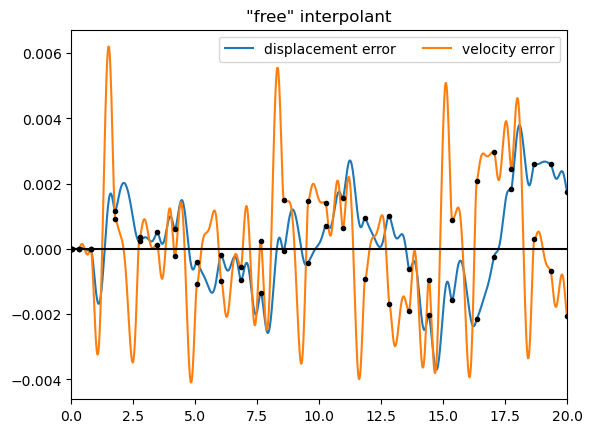

In [9]:

for interpolant, sol in zip(reversed(interpolants), 
                            [sol_best, sol_low, sol_free]):
    plt.figure()
    e_main = sol.y - sol_ref.sol(sol.t)
    e_interpolator = sol.sol(t_fine) - sol_ref.sol(t_fine)
    plt.plot(t_fine, e_interpolator.T)
    plt.plot(sol.t, e_main.T, '.k')
    plt.xlim((t_fine[0], t_fine[-1]))
    plt.axhline(0, color='k')
    plt.legend(("displacement error", "velocity error"), ncol=2)
    plt.title(f'"{interpolant}" interpolant')
plt.show()

Now the result of the 'best' interpolant is nice and smooth between the dots of the main solution. These dots are at exactly the same location in each of the figures of course. Only the interpolants are different, not the main solutions. Errors do accumulate in the main solution. For that reason, the accuracy of the main methods is of greater importance than the accuracy of the interpolants.

The bottom figure shows the results of the 'free' interpolant. The errors from this interpolant are much larger than the errors in the main method; certainly in the first half of the solution.

The 'low' interpolant behaves somewhere in-between. Its error plot looks much cleaner than that of the 'free' interpolant, but clearly worse than that of the 'best' interpolant. I have selected this 'low' cost interpolant as the default for `BS5` in Extensisq, because it improves the accuracy significantly, while the overall efficiency is not reduced by much. Moreover, it fits the main idea of being at least as good as DP5.

## Conclusions

The aim of Bogacki and Shampine with the `BS5` method was to make it more efficient than DP5 and at least as stable. I think they have delivered.

The interpolants of this method can trigger extra function evaluations that reduce the overall efficiency. As rule of thumb:
* Use the 'best' interpolant (3 extra evaluations per step) for event tracking.
* Use the 'free' interpolant (no extra evaluations) for plotting smooth figures.
* Use the 'low' cost interpolant (default in Extensiq, 1 extra evaluation per step) if you don't want to be bothered with this. It's accurate and efficient enough in most cases for which `BS5` is a good choice.